# Neural Style Transfer Exp:6
Context [here](https://dhruvs.space/posts/neural-style-transfer/).

Things explored:
- Reconstruction on screenshots

See animations on [nbviewer](https://nbviewer.jupyter.org/github/dhth/neural-style-transfer-exps/blob/master/exp_6.ipynb).

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install -q fastai==0.7.0 torchtext==0.2.3
!apt -qq install imagemagick

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
from math import ceil
from decimal import Decimal
from IPython.display import HTML

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
class NeuralStyleTransfer(object):
    
    def __init__(self,base_model,sz):
        self.base_model = base_model
        self.sz = sz
        self.model = to_gpu(base_model(True)).eval()
        set_trainable(self.model, False)
        self.trn_tfms,self.val_tfms = tfms_from_model(self.base_model, self.sz)
        
    def get_opt(self,img):
        opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
        opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
        opt_img_v = V(self.val_tfms(opt_img/2)[None], requires_grad=True)
        return opt_img_v, optim.LBFGS([opt_img_v])
    
    def step(self,loss_fn):
        self.optimizer.zero_grad()
        loss = loss_fn(self.opt_img_v)
        loss.backward()
        self.n_iter+=1
#         if self.print_losses:
#             if self.n_iter%self.show_iter==0: print(f'Iteration: {self.n_iter}, loss: {loss.data[0]}')
        return loss

    def scale_match(self, src, targ):
        h,w,_ = src.shape
        sh,sw,_ = targ.shape
        rat = max(h/sh,w/sw); rat
        res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
        return res[:h,:w]
    
    def gram(self,input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

    def gram_mse_loss(self,input, target):
        return F.mse_loss(self.gram(input), self.gram(target))
    
    def comb_loss(self,x):
        self.model(self.opt_img_v)
        content_outs = [V(o.features) for o in self.content_sfs]
        style_outs = [V(o.features) for o in self.style_sfs]
        
#         content_loss
        content_losses   = [F.mse_loss(o, s) 
                        for o,s in zip(content_outs, self.targ_vs)]
    
#         style_loss
        style_losses = [self.gram_mse_loss(o, s) 
                        for o,s in zip(style_outs, self.targ_styles)]

    
        if self.content_layers_weights is None:
            content_loss = sum(content_losses)
        else:
            content_loss = sum([a*b for a,b in 
                                zip(content_losses,self.content_layers_weights)])
            
        if self.style_layers_weights is None:
            style_loss = sum(style_losses)
        else:
            style_loss = sum([a*b for a,b in 
                              zip(style_losses,self.style_layers_weights)])
        if self.print_losses:
            if self.n_iter%self.show_iter==0:
                print(f'content: {self.alpha*content_loss.data[0]}, style: {self.beta*style_loss.data[0]}')
        
        if self.return_intermediates and self.n_iter<=self.gif_iter_till:
            if self.n_iter%self.gif_iter==0:
                self.intermediate_images.append(self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0])
        
        return self.alpha*content_loss + self.beta*style_loss

    def generate(self, content_image, style_img,
                 style_layers, content_layers,
                 alpha=1e6,
                 beta=1.,
                 content_layers_weights=None,
                 style_layers_weights=None,
                 max_iter=500,show_iter=300,
                 print_losses=False,
                 scale_style_img=True,
                 return_intermediates=False,
                 gif_iter=50,
                 gif_iter_till=500):
        
        self.max_iter = max_iter
        self.show_iter = show_iter
        self.gif_iter = gif_iter
        self.gif_iter_till = gif_iter_till
        
        self.alpha = alpha
        self.beta = beta
        self.content_layers_weights = content_layers_weights
        self.style_layers_weights = style_layers_weights
        self.print_losses = print_losses
        self.return_intermediates = return_intermediates
        self.intermediate_images = []

        self.content_sfs = [SaveFeatures(children(self.model)[idx]) for idx in content_layers]
        
        self.style_sfs = [SaveFeatures(children(self.model)[idx]) for idx in style_layers]
        
#         get target content
        img_tfm = self.val_tfms(content_image)
        self.opt_img_v, self.optimizer = self.get_opt(content_image)
        self.model(VV(img_tfm[None]))
        self.targ_vs = [V(o.features.clone()) for o in self.content_sfs]

#         get target style
        if scale_style_img:
            style_img = self.scale_match(content_image, style_img)
        self.style_tfm = self.val_tfms(style_img)
        self.model(VV(self.style_tfm[None]))
        self.targ_styles = [V(o.features.clone()) for o in self.style_sfs]
        
        self.n_iter=0

        while self.n_iter <= self.max_iter: self.optimizer.step(partial(self.step,self.comb_loss))
        for sf in self.content_sfs: sf.close()
        for sf in self.style_sfs: sf.close()
        if not self.return_intermediates:
            return self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0]
        else:
            return self.intermediate_images

In [0]:
PATH = Path('data/imagenet')
PATH_IMAGES = PATH/'images'
PATH_STYLE = PATH/'style'

!mkdir -p {PATH_IMAGES}
!mkdir -p {PATH_STYLE}

# !wget -qq https://previews.123rf.com/images/illucesco/illucesco1605/illucesco160500035/57523087-simple-doodle-flower-hand-drawn-vector-illustration.jpg -O {PATH_IMAGES}/farm.jpg
# content_img = open_image(PATH_IMAGES/'farm.jpg')

# !wget -qq https://media.overstockart.com/optimized/cache/data/product_images/VG1540-1000x1000.jpg -O {PATH_STYLE}/'cafe_terrace.jpg'
# style_img = open_image(PATH_STYLE/'cafe_terrace.jpg')

# images = [content_img,style_img]
# titles = ['content image', 'style image']

# fig,axes = plt.subplots(1,2,figsize=(10,5))
# for i,ax in enumerate(axes.flat):
#     ax.grid(False)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     ax.set_title(titles[i])
#     ax.imshow(images[i]);
# plt.tight_layout()
# plt.show()

In [0]:
def show_images(images):
    num_cols = 2
    num_rows = ceil(len(images)/num_cols)
    img_size = 4
    fig,axes = plt.subplots(num_rows,num_cols,
                            figsize=(img_size*num_cols,img_size*num_rows))
    for i,ax in enumerate(axes.flat):
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
#         ax.set_title(titles[i])
        ax.imshow(images[i]);
    plt.tight_layout()
    plt.show()

In [0]:
def show_img(images):
    num_cols = 3
    num_rows = len(images)//3
    fig,axes = plt.subplots(num_rows,3,figsize=(num_rows*,5))
    for i,ax in enumerate(axes.flat):
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(titles[i])
        ax.imshow(images[i]);
    plt.tight_layout()
    plt.show()

In [0]:
t2 = NeuralStyleTransfer(vgg16,288)

In [0]:
def generate_anim(content_img, style_img,
                   gif_name,
                   content_layers=[16,22,26],
                   style_layers=[9,12,16,22,26],
                   alpha=1e5,
                   beta=3.,
                   style_layers_weights=None,
                   max_iter=800,show_iter=100,
                   print_losses=True,
                   scale_style_img=True,
                   return_intermediates=True,
                   gif_iter=10,
                   gif_iter_till=200):

    imgs = t2.generate(content_img, style_img,
                           content_layers=content_layers,
                           style_layers=style_layers,
                           alpha=alpha,
                           beta=beta,
                           style_layers_weights=style_layers_weights,
                           max_iter=max_iter,show_iter=show_iter,
                           print_losses=print_losses,
                           scale_style_img=scale_style_img,
                           return_intermediates=True,
                           gif_iter=gif_iter,
                           gif_iter_till=gif_iter_till)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.tight_layout()
    ims = []
    for i,img in enumerate(imgs):
        txt = plt.text(10,15,f'{i*gif_iter}',color='white', fontsize=16, weight='bold')
        im = ax.imshow(np.clip(img, 0, 1), interpolation='lanczos', animated=True)

        ims.append([im,txt])

    ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True,
                                repeat=False)
    plt.close()
#     ani.save(gif_name, writer='imagemagick', fps=2)
    return ani

In [0]:
def image_from_url(url,name):
    !wget -qq {url} -O {PATH_IMAGES}/{name}.jpg
    return open_image(PATH_IMAGES/(name+'.jpg'))

In [0]:
def reconstruct(content_img, style_img,
                   content_layers=[19,22],
                   style_layers=[9,12,16,22,],
                   alpha=1e5,
                   beta=1.,
                   scale_style_img=True,
                   max_iter=1000,show_iter=100,
                   print_losses=True):
    
    fig,ax = plt.subplots(1,1, figsize=(6,6))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    gen4 = t2.generate(content_img, style_img,
                       content_layers=content_layers,
                       style_layers=style_layers,
                       alpha=alpha,
                       beta=beta,
                       scale_style_img=scale_style_img,
                       max_iter=max_iter,show_iter=show_iter,
                       print_losses=print_losses)

    x = np.clip(gen4, 0, 1)
    ax.imshow(x,interpolation='lanczos')
    plt.show()
    return x

In [0]:
# get token from
# https://api.imgur.com/oauth2/authorize?client_id=CLIENT_ID&response_type=token&state=none

In [0]:
import requests

In [0]:
import base64

In [0]:
import pprint

In [0]:
def upload_to_imgur(file_name,post_title,album_hash):
    url = 'https://api.imgur.com/3/image'
    fh = open(file_name, 'rb');
    payload = {'image': base64.b64encode(fh.read()),
              'album':album_hash,
              'type':'base64',
              'title':post_title,
              'looping':False
              }
    files = {}
    headers = {
      'Authorization': f'Bearer {ACCESS_TOKEN}'
    }
    response = requests.request('POST', url, headers = headers, data = payload, files = files, allow_redirects=False)
    print(response.json()['data']['link'])

In [0]:
starry_night = image_from_url('https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg','starry_night')

In [0]:
def get_image_info(image_hash):
    
    url = f'https://api.imgur.com/3/image/{image_hash}'

    headers = {
      'Authorization': f'Bearer {ACCESS_TOKEN}'
    }
    response = requests.request('GET', url, headers = headers,allow_redirects=False)
    pprint.pprint(response.json())

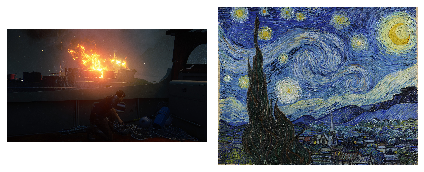

In [25]:
uc4_blast = image_from_url('https://i.imgur.com/Tb4NBSU.jpg','uc4_blast')
show_images([uc4_blast,starry_night])

In [0]:
uc4_car = image_from_url('https://i.imgur.com/ZygvVHR.jpg','uc4_car')
rainy = image_from_url('http://gordon-bruce-art.weebly.com/uploads/1/6/7/2/1672224/editor/rainy-day-tram.jpg?1528805334','rainy')
show_images([uc4_car,rainy])


In [0]:
x = reconstruct(uc4_car,rainy,alpha=1e6,
                   beta=15.,max_iter=400)

In [0]:
def generate_anim_2(content_img, style_img,
                   cell_size=3,
                   save_name=None,
                   content_layers=[16,22,26],
                   style_layers=[9,12,16,22,26],
                   alpha=1e5,
                   beta=3.,
                   style_layers_weights=None,
                   max_iter=800,show_iter=100,
                   print_losses=True,
                   scale_style_img=True,
                   return_intermediates=True,
                   gif_iter=10,
                   gif_iter_till=200,
                   fps=3):

    imgs = t2.generate(content_img, style_img,
                           content_layers=content_layers,
                           style_layers=style_layers,
                           alpha=alpha,
                           beta=beta,
                           style_layers_weights=style_layers_weights,
                           max_iter=max_iter,show_iter=show_iter,
                           print_losses=print_losses,
                           scale_style_img=scale_style_img,
                           return_intermediates=True,
                           gif_iter=gif_iter,
                           gif_iter_till=gif_iter_till)

    fig = plt.figure(figsize=(cell_size*3,cell_size*2))
    gs = gridspec.GridSpec(2, 3)
    content_ax = plt.subplot(gs[0, 0])
    reconstructed_ax = plt.subplot(gs[0:, 1:])
    style_ax = plt.subplot(gs[1, 0])

    for ax in [content_ax,reconstructed_ax,style_ax]:
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    content_img_tfmd = t2.val_tfms.denorm(np.rollaxis(t2.val_tfms(content_img)[None],1,4))[0]    
    style_img_scaled = t2.scale_match(content_img_tfmd, style_img)
    style_img_tfmd = t2.val_tfms.denorm(np.rollaxis(t2.val_tfms(style_img_scaled)[None],1,4))[0]


    # fig.tight_layout()

    c_im = content_ax.imshow(content_img_tfmd)
    c_txt = content_ax.set_title('content')
    rec_txt = reconstructed_ax.set_title('reconstruction')
    st_im = style_ax.imshow(style_img_tfmd)
    st_txt = style_ax.set_title('style')
    btm_txt = reconstructed_ax.text(.93,-0.03, "by dhruv", size=12, ha="center", 
                 transform=reconstructed_ax.transAxes)

    ims = []
    for i,img in enumerate(imgs):

        txt = reconstructed_ax.text(content_img_tfmd.shape[0]*0.04,content_img_tfmd.shape[0]*0.05,f'{i*gif_iter}',color='white', fontsize=16, weight='bold')
        im = reconstructed_ax.imshow(np.clip(img, 0, 1), interpolation='lanczos', animated=True)
        ims.append([im,txt])

    ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True,
                                repeat=False)
    plt.tight_layout()
    plt.close()
    if save_name is not None:
        ani.save(save_name, writer='imagemagick', fps=fps)
    return ani

In [0]:
import matplotlib.gridspec as gridspec

In [0]:
def plot_result(content_img,style_img,reconstructed,
                save_name=None,
                cell_size=3):
    fig = plt.figure(figsize=(cell_size*3,cell_size*2))
    gs = gridspec.GridSpec(2, 3)
    content_ax = plt.subplot(gs[0, 0])
    reconstructed_ax = plt.subplot(gs[0:, 1:])
    style_ax = plt.subplot(gs[1, 0])

    for ax in [content_ax,reconstructed_ax,style_ax]:
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    content_img_tfmd = t2.val_tfms.denorm(np.rollaxis(t2.val_tfms(content_img)[None],1,4))[0]    
    style_img_scaled = t2.scale_match(content_img_tfmd, style_img)
    style_img_tfmd = t2.val_tfms.denorm(np.rollaxis(t2.val_tfms(style_img_scaled)[None],1,4))[0]

    content_ax.imshow(content_img_tfmd)
    content_ax.set_title('content')
    reconstructed_ax.imshow(reconstructed)
    reconstructed_ax.set_title('reconstructed')
    style_ax.imshow(style_img_tfmd)
    style_ax.set_title('style')
    reconstructed_ax.text(.95,-0.02, "by dhruv", size=12, ha="center", 
         transform=reconstructed_ax.transAxes)
    plt.tight_layout()
    if not save_name is None:
        plt.savefig(save_name)
    plt.show()

In [0]:
t2 = NeuralStyleTransfer(vgg16,800)

In [0]:
x = reconstruct(uc4_blast,starry_night,alpha=3e5,
                   beta=15.,max_iter=1000)

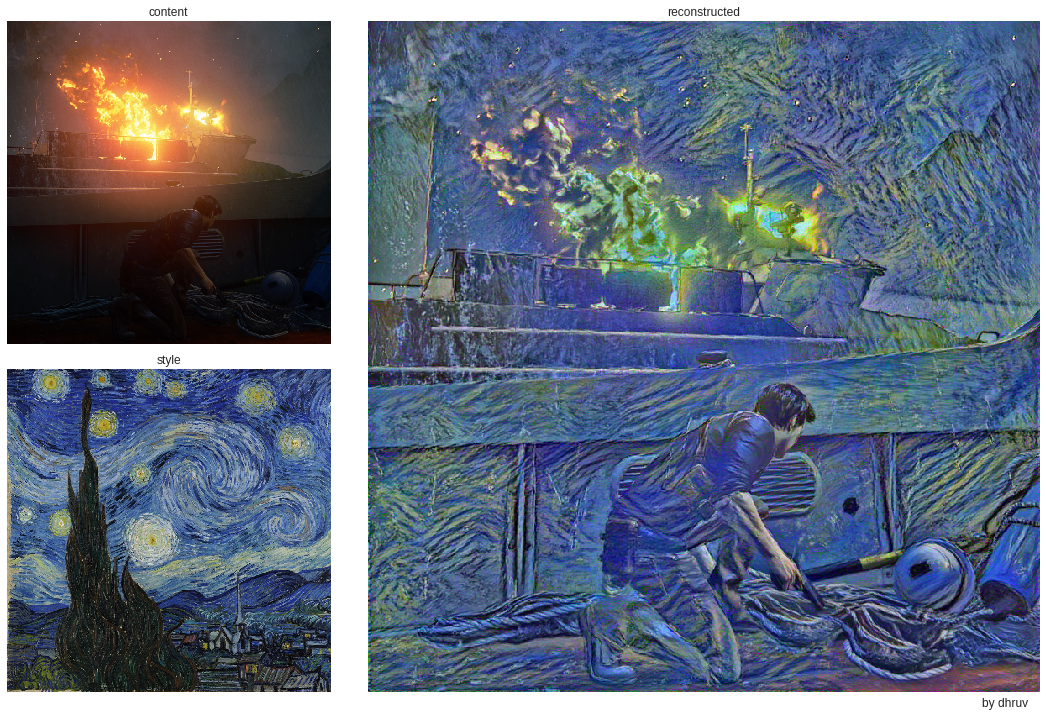

In [103]:
plot_result(uc4_blast,starry_night,x,cell_size=5,save_name='uncharted4_blast.png')

In [106]:
upload_to_imgur('uncharted4_blast.png','Style Transfer: Uncharted 4 and Starry Night','YhSqqsO')

https://i.imgur.com/W9Hwixh.png


In [110]:
ani0 = generate_anim_2(uc4_blast,starry_night,save_name='uc4_blast.gif',
                       alpha=3e5,beta=15.,
                       max_iter=240,gif_iter=20,gif_iter_till=240)
HTML(ani0.to_html5_video())

content: 10173.30251634121, style: 132649.5263671875
content: 5013.399012386799, style: 876.2719345092773
content: 3706.8240344524384, style: 561.0199356079102


In [111]:
upload_to_imgur('uc4_blast.gif','Style Transfer: Uncharted 4 and Starry Night','YhSqqsO')

https://i.imgur.com/zVQdVtj.gif
